In [ ]:
!pip install qiskit qiskit-aer qiskit-ibm-provider qiskit-ibm-runtime matplotlib numpy
!pip install -U qiskit

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import (
    plot_bloch_vector,
    plot_bloch_multivector,
    plot_histogram
)
from qiskit.quantum_info import (
    Statevector,
    Operator,
    Pauli
)
from qiskit.circuit.library import CXGate, CCXGate, SwapGate
from qiskit.visualization.bloch import Bloch
import matplotlib.pyplot as plt
import numpy as np
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session


#### Vetores e matrizes em Python

O Qiskit utiliza a linguagem de programação Python, então, antes de discutirmos o Qiskit especificamente, pode ser útil falar brevemente sobre cálculos com matrizes e vetores em Python. Em Python, cálculos com matrizes e vetores podem ser realizados usando a classe `array` da biblioteca NumPy (que inclui muitos outros componentes para computação numérica).

Aqui está um exemplo de uma célula de código que define dois vetores, `ket0` e `ket1`, correspondentes aos vetores de estado de qubit ∣0⟩ e ∣1⟩, e exibe sua média.

In [ ]:
from numpy import array

ket0 = array([1, 0])
ket1 = array([0, 1])

display(ket0 / 2 + ket1 / 2)

array([0.5, 0.5])

#### Estados, medidas e operações

O Qiskit inclui várias classes que permitem que estados, medições e operações sejam facilmente criados e manipulados — portanto, não é necessário começar do zero e programar tudo o que é necessário para simular estados quânticos, medições e operações em Python. Alguns exemplos para começar estão incluídos abaixo.

Definindo e exibindo vetores de estado

A classe `Statevector` do Qiskit fornece funcionalidades para definir e manipular vetores de estado quânticos. A célula de código a seguir importa a classe `Statevector` e define alguns vetores utilizando-a. (Observe que precisamos da função `sqrt` da biblioteca NumPy para calcular as raízes quadradas do vetor `u`.)

A classe `Statevector` também inclui o método `is_valid`, que verifica se um determinado vetor é um vetor de estado quântico válido (ou seja, se tem norma Euclidiana igual a 1):

In [ ]:
from numpy import sqrt

u = Statevector([1 / sqrt(2), 1 / sqrt(2)])
v = Statevector([(1 + 2.0j) / 3, -2 / 3])
w = Statevector([1 / 3, 2 / 3])

display(u.draw("latex"))
display(v.draw("text"))

display(u.is_valid())
display(w.is_valid())

<IPython.core.display.Latex object>

[ 0.33333333+0.66666667j,-0.66666667+0.j        ]

True

False

#### Visualizando Estados Quânticos na Esfera de Bloch com Qiskit

Estaremos visualizando os estados anteriores na Esfera de Bloch. Importante destacar que não estamos descrevendo circuitos nem executando em hardware real — estamos apenas manipulando matematicamente vetores de estado usando a classe `Statevector` do Qiskit, o que nos permite analisar diretamente a estrutura dos estados quânticos. Para isso, utilizamos a função `state_to_bloch`, que converte um vetor de estado em um vetor 3D real na esfera de Bloch. Essa conversão é feita através do cálculo dos valores esperados dos operadores de Pauli \( X \), \( Y \) e \( Z \), com a função `expectation_value(Pauli('X'))` retornando, por exemplo, \(\langle \psi | X | \psi \rangle\), ou seja, o valor médio da medição no eixo X. Esses valores, extraídos das componentes reais das expectativas, fornecem diretamente as coordenadas cartesianas \([x, y, z]\) da esfera. Essa abordagem é extremamente útil para visualizações rápidas e análises teóricas, pois ignora ruídos, decoerência e outras limitações dos simuladores e dispositivos quânticos reais.


In [ ]:
%matplotlib inline


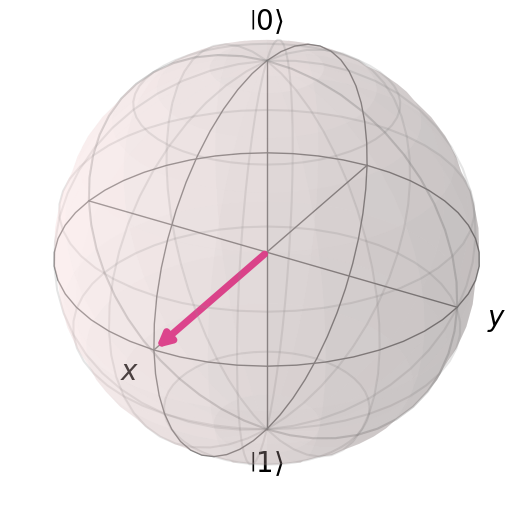

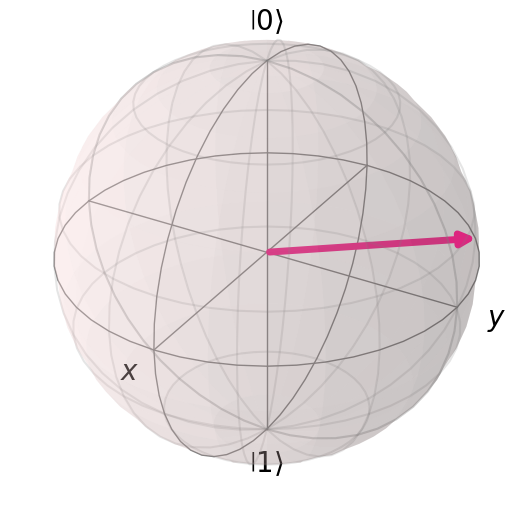

In [ ]:
def state_to_bloch(state):
    x = np.real(state.expectation_value(Pauli('X')))
    y = np.real(state.expectation_value(Pauli('Y')))
    z = np.real(state.expectation_value(Pauli('Z')))
    return [x, y, z]

estados = [('u', u), ('v', v)]

for label, state in estados:
    vector = state_to_bloch(state)
    b = Bloch()
    b.add_vectors(vector)
    b.title = f"Estado {label}"
    b.show()

#### Exercício 01:

Defina mais vetores de estado, verifique se são válidos, visualize eles e plote a esfera de bloch para eles. (Apenas integre o estado ao vetor de estados e rode o loop novamente)

#### Operações Unitárias matematicamente

Operações unitárias podem ser definidas e realizadas em vetores de estado no Qiskit utilizando a classe `Operator`, como no exemplo a seguir. Assim, nós mesmos podemos descrever o operador


In [ ]:
X = Operator([[0, 1], [1, 0]])
Y = Operator([[0, -1.0j], [1.0j, 0]])
Z = Operator([[1, 0], [0, -1]])
H = Operator([[1 / sqrt(2), 1 / sqrt(2)], [1 / sqrt(2), -1 / sqrt(2)]])

v = Statevector([1, 0])
v = v.evolve(H)
v.draw("text")

[0.70710678+0.j,0.70710678+0.j]

#### Múltiplos Estados e produto tensorial

A classe `Statevector` possui um método chamado `tensor`, que retorna o produto tensorial daquele `Statevector` com outro, fornecido como argumento. O argumento é interpretado como o fator tensorial à direita.

Por exemplo, abaixo criamos dois vetores de estado representando ∣0⟩ e ∣1⟩, e usamos o método `tensor` para criar um novo vetor, ∣ψ⟩ = ∣0⟩ ⊗ ∣1⟩. Observe que aqui estamos utilizando o método `from_label` para definir os estados ∣0⟩ e ∣1⟩, em vez de defini-los manualmente.

In [ ]:
zero = Statevector.from_label("0")
one = Statevector.from_label("1")
psi = zero.tensor(one)
display(psi.draw("latex"))

<IPython.core.display.Latex object>

#### Execício 02:

 Defina os dois estados abaixo e faça o produto tensorial deles depois observe e veja se está correto:

![image.png](attachment:image.png)

#### Principais portas lógicas

A classe `Operator` também possui um método `tensor` (assim como um método `from_label`), como veremos nos exemplos a seguir.

In [ ]:
H = Operator.from_label("H")
I = Operator.from_label("I")
X = Operator.from_label("X")

CNOT = Operator(CXGate())
TOFFOLI = Operator(CCXGate())
SWAP = Operator(SwapGate())

display(H.draw("latex"))
display(I.draw("latex"))
display(X.draw("latex"))

display(H.tensor(I).draw("latex"))
display(H.tensor(I).tensor(X).draw("latex"))

print("CNOT: ")
display(CNOT.draw("latex"))
print("TOFFOLI: ")
display(TOFFOLI.draw("latex"))
print("SWAP: ")
display(SWAP.draw("latex"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

CNOT: 


<IPython.core.display.Latex object>

TOFFOLI: 


<IPython.core.display.Latex object>

SWAP: 


<IPython.core.display.Latex object>

#### Simulando medições usando Statevector
A seguir, veremos uma forma de simular medições de estados quânticos no Qiskit, utilizando o método measure da classe Statevector.

Primeiro, criamos um vetor de estado de qubit v e, em seguida, o exibimos.

Em seguida, ao executar o método measure, é simulada uma medição na base padrão. Ele retorna o resultado dessa medição, além do novo estado quântico do nosso sistema após a medição.

A classe Statevector também possui o método sample_counts, que permite simular qualquer número de medições no sistema. Por exemplo, a célula de código a seguir mostra o resultado de medir o vetor v 1000 vezes, o que (com alta probabilidade) resulta no resultado 0 aproximadamente 5 em cada 9 vezes (ou cerca de 556 das 1000 tentativas) e o resultado 1 aproximadamente 4 em cada 9 vezes (ou cerca de 444 das 1000 tentativas). A célula também demonstra a função plot_histogram para visualizar os resultados.

<IPython.core.display.Latex object>

(np.str_('0'),
 Statevector([0.4472136+0.89442719j, 0.       +0.j        ],
             dims=(2,)))

{np.str_('0'): np.int64(546), np.str_('1'): np.int64(454)}

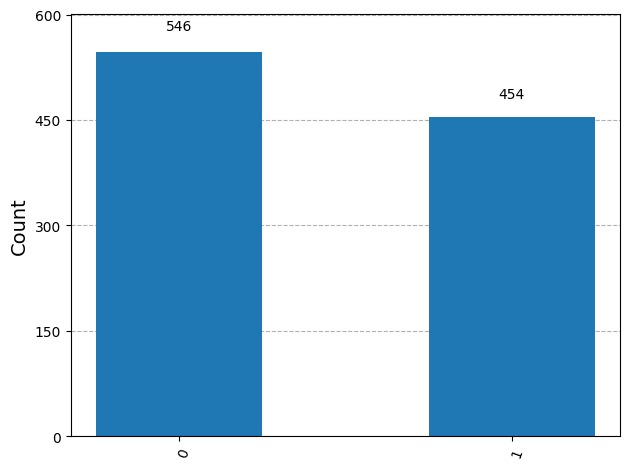

In [ ]:
v = Statevector([(1 + 2.0j) / 3, -2 / 3])

display(v.draw("latex"))

display(v.measure())

statistics = v.sample_counts(1000)

display(statistics)

plot_histogram(statistics)

Na lição anterior, usamos o método measure para simular uma medição de um vetor de estado quântico. Esse método retorna dois itens: o resultado simulado da medição e o novo Statevector resultante dessa medição.

Por padrão, measure mede todos os qubits no vetor de estado. Alternativamente, podemos fornecer uma lista de inteiros como argumento, o que faz com que apenas os qubits com esses índices sejam medidos. Para demonstrar isso, o código abaixo cria o estado

∣w⟩ = (∣001⟩ + ∣010⟩ + ∣100⟩) / √3

e mede o qubit de número 0, que é o qubit mais à direita.

In [ ]:
w = Statevector([0, 1, 1, 0, 1, 0, 0, 0] / sqrt(3))
display(w.draw("latex"))

result, state = w.measure([0])
print(f"Measured: {result}\nState after measurement:")
display(state.draw("latex"))

result, state = w.measure([0,1])
print(f"Measured: {result}\nState after measurement:")
display(state.draw("latex"))

<IPython.core.display.Latex object>

Measured: 1
State after measurement:


<IPython.core.display.Latex object>

Measured: 00
State after measurement:


<IPython.core.display.Latex object>

#### Construindo circuitos reais com Qiskit

Agora, vamos descrever essas mesmas operações como circuitos quânticos, que é como elas seriam realmente programadas para execução em um simulador quântico ou computador quântico real.

Você começa com QuantumCircuit(n), criando n qubits. Em vez de definir vetores diretamente, você configura estados através de portas quânticas.

In [ ]:
qc = QuantumCircuit(1)
qc.initialize([1/np.sqrt(2), 1/np.sqrt(2)], 0) #Equivalente ao Statevector([1/√2, 1/√2])
qc.draw('text')

┌─────────────────────────────┐
q: ┤ Initialize(0.70711,0.70711) ├
   └─────────────────────────────┘

##### Operações Unitárias

Cada Operator que você criou (X, Y, Z, H...) corresponde a uma porta de circuito real.

Você também pode usar qc.unitary(Operator(...), qubit_idx) para inserir gates personalizados.

In [ ]:
qc.h(0)  # Hadamard
qc.x(0)  # Pauli-X
qc.draw('text')

┌─────────────────────────────┐┌───┐┌───┐
q: ┤ Initialize(0.70711,0.70711) ├┤ H ├┤ X ├
   └─────────────────────────────┘└───┘└───┘

##### Múltiplos Qubits

Ao invés de usar .tensor(), você define vários qubits no circuito e aplica operações em cada um:

In [ ]:
qc2 = QuantumCircuit(2)
qc2.x(0)
qc2.swap(0, 1)
qc2.draw('text')

┌───┐   
q_0: ┤ X ├─X─
     └───┘ │ 
q_1: ──────X─

##### Medições

Use qc.measure() para transformar os estados em resultados clássicos — como na vida real:

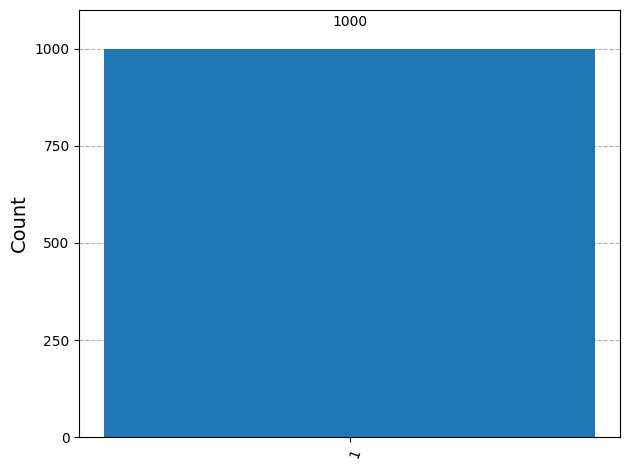

In [ ]:
qc.measure_all()

simulator = Aer.get_backend('qasm_simulator')
job = simulator.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

#### Visualizações (com base em circuitos):

Você pode extrair o vetor de estado do circuito e exibir na Esfera de Bloch com:

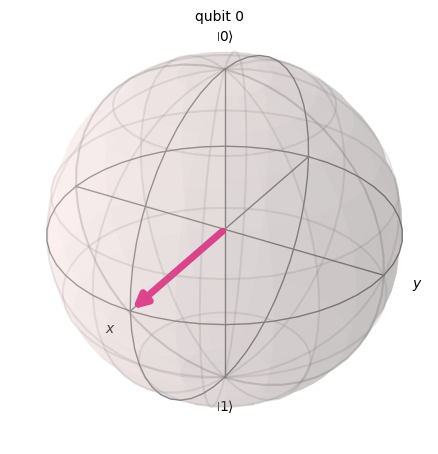

In [ ]:
qc = QuantumCircuit(1)
qc.h(0)

state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

##### Exercício 03

Faça um circuito com dois qubits entrelaçados e verifique seu entrelaçamento e faça medições no backend


##### Exercício 04

Faça operações flip de fase e estado em um circuito e visualize na esfera de bloch e compare com estados básicos